# O Problema do Caxeiro Viajante
<b>SME0110 - Programação Matemática || Bach. Ciências de Computação || ICMC/USP<br>
Alunos: João Garcia Coelho (------) & Matheus AParecido do Carmo Alves (9791114)</b>

Este projeto tem como propostao estudar e implementar o modelo para resolução do problema do caixeiro viajante com as restrições de eliminação de sub-rotas do tipo MTZ (Otimização Inteira Mista).

Para a realização de testes e estudo, será utilizado o conjunto de dados <a href='https://wwwproxy.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/tsp/burma14.tsp.gz'>Burma14</a> e outras três <a href='http://elib.zib.de/pub/mp-testdata/tsp/tsplib/tsp/index.html'>instâncias disponíveis</a>,  sendo elas: "ulysses16", "bays29" e "berlin52".

## 1. Instalando e carregando pacotes necessários

Primeiramente, iremos instalar (caso necessário) e incluir os pacotes necessários para a execução do projeto.
Serão eles:
<ul>
    <li><b>JuMP</b>: Pacote de modelos para otimização matemática em Julia.</li>
    <li><b>GLPK</b>: Pacote para programação linear do GNU para Julia.</li>
    <li><b>Distances</b>: Pacote para calculo de distâncias em Julia.</li>
    <li><b>Plots e Graphs Recipes</b>: Pacotes para desenhar o grafo montado.</li>
    <li><b>LightGraphs e SimpleWeightedGraphs</b>: Pacotes para montar grafos.</li>
</ul>

Para isso, usamos o seguintes comandos:

In [1]:
# Installing the packages
using Pkg
#Pkg.add("JuMP")
#Pkg.add("GLPK")
#Pkg.add("Distances")
#Pkg.add("Plots") 
#Pkg.add("GraphRecipes")
#Pkg.add("LightGraphs")
#Pkg.add("SimpleWeightedGraphs")

# Including the packages
using JuMP, GLPK, Distances, Plots, GraphRecipes, LightGraphs, SimpleWeightedGraphs

Agora, vamos a resolução dos problemas do caixeiro viajante. 

## Burma14

Primeiramente, vamos carregar o arquivo de estudo para construção do problema.

In [2]:
file_name = "burma14.txt"

# 1. Carregando o arquivo de estudo
file = open("./" * file_name);
lines = readlines(file)
N = length(lines)

println("Numero de nós: ", N)

Numero de nós: 14


Com o arquivo carregado, iremos formatar os dados, extraindo as informações que desejamos.

O primeiro passo é extrair as informações do arquivo de entrada:

In [3]:
# 2. Extraindo as informações do arquivo de entrada
c = [Vector{Float64}(undef, 2) for _ in 1:N]

for i = 1:N
    x, y = split(lines[i],',')
    c[i] = [parse(Float64, x), parse(Float64, y)]
end

Extraída as informações, iremos calcular a matriz de distâncias.

In [4]:
# 3. Calculando a matriz de distancias
dist_mat = zeros(N,N)
for i=1:N, j=i+1:N
    d = euclidean(c[i],c[j])
    dist_mat[i,j] = d
    dist_mat[j,i] = d
end

Podemos visualizar a rede a qual estamos trabalhando da seguinte forma:

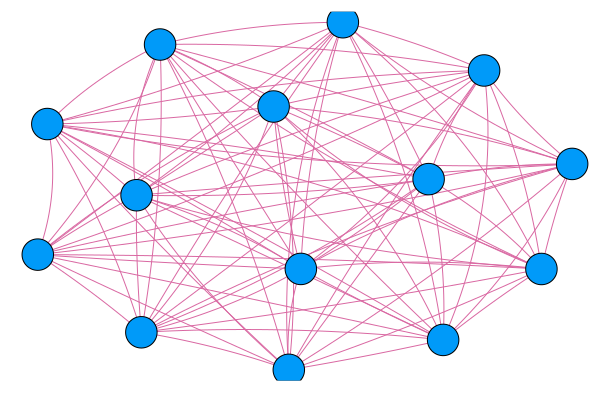

In [5]:
# 4. Plotando o grafo do problema
g = WGraph(N)
for i = 1:N
    for j = i+1:N
        add_edge!(g, i, j, dist_mat[i,j])
    end
end
graphplot(g)

Agora iremos criar o modelo para resolução do problema.

In [6]:
# 5. Realizando a otimização inteira mista - MTZ
m = Model(with_optimizer(GLPK.Optimizer))

@variable(m, x[1:N,1:N], Bin)
@objective(m, Min, sum(x[i,j]*dist_mat[i,j] for i=1:N,j=1:N))
for i=1:N 
    @constraint(m, x[i,i] == 0)
    @constraint(m, sum(x[i,1:N]) == 1)
end
for j=1:N
    @constraint(m, sum(x[1:N,j]) == 1)
end
for f=1:N, t=1:N
    @constraint(m, x[f,t]+x[t,f] <= 1)
end

optimize!(m)
println("Resultado da função objetivo: ", JuMP.objective_value(m))

Resultado da função objetivo: 28.460153369813938


Vizando generalizar o código, podemos criar a seguinte função para execução da otimização do problema do caixeiro viajante.

In [7]:
function tsp(file_name)
    # 1. Carregando o arquivo de estudo
    file = open(file_name);
    lines = readlines(file)
    N = length(lines)
    println("Numero de nós: ", N)
    
    # 2. Extraindo as informações do arquivo de entrada
    c = [Vector{Float64}(undef, 2) for _ in 1:N]
    for i = 1:N
        x, y = split(lines[i],',')
        c[i] = [parse(Float64, x), parse(Float64, y)]
    end
    
    # 3. Calculando a matriz de distancias
    dist_mat = zeros(N,N)
    for i=1:N, j=i+1:N
        d = euclidean(c[i],c[j])
        dist_mat[i,j] = d
        dist_mat[j,i] = d
    end
    
    # 4. Plotando o grafo do problema
    g = WGraph(N)
    for i = 1:N
        for j = i+1:N
            add_edge!(g, i, j, dist_mat[i,j])
        end
    end
    graphplot(g)
    
    # 5. Realizando a otimização inteira mista - MTZ
    m = Model(with_optimizer(GLPK.Optimizer))

    @variable(m, x[1:N,1:N], Bin)
    @objective(m, Min, sum(x[i,j]*dist_mat[i,j] for i=1:N,j=1:N))
    for i=1:N 
        @constraint(m, x[i,i] == 0)
        @constraint(m, sum(x[i,1:N]) == 1)
    end
    for j=1:N
        @constraint(m, sum(x[1:N,j]) == 1)
    end
    for f=1:N, t=1:N
        @constraint(m, x[f,t]+x[t,f] <= 1)
    end

    optimize!(m)
    println("Resultado da função objetivo: ", JuMP.objective_value(m))
    
end

tsp (generic function with 1 method)

Como já possuímos a função genérica, podemos verificar facilmente a solução de outros datasets a partir desta.

Desta forma, iremos aplicar este método sobre os outros 3 datasets mencionados na introdução.

## Ulysses16

In [8]:
tsp("./ulysses16.txt")

Numero de nós: 16
Resultado da função objetivo: 63.17887951787364


## Bays29

In [9]:
tsp("./bays29.txt")

Numero de nós: 29
Resultado da função objetivo: 8717.437122346637


## Berlin52

In [10]:
tsp("./berlin52.txt")

Numero de nós: 52
Resultado da função objetivo: 7167.199607869789
